# Module 4A: Bits, Pixels, and Medical Images
## From Binary Representation to Frontal vs Lateral Chest X-ray Classification

**Goal:** Understand how image information is encoded (1-bit -> 16-bit), how CT windowing works, and then build a view-classification baseline (Frontal vs Lateral) with traditional ML and a compact CNN.


### Why this module?
Before training imaging models, we need a clear mental model of:
- how pixels encode information,
- why medical images often use higher bit depth,
- and how that connects to real clinical tasks.


### Learning objectives
1. Explain how 1-bit, 2-bit, 4-bit, 8-bit, and 16-bit representations differ.
2. Visualize how more bits create more intensity levels.
3. Interpret 8-bit grayscale and 8-bit RGB pixel structures.
4. Load a 16-bit CT DICOM slice and convert raw values to Hounsfield Units (HU).
5. Apply lung and bone windowing and explain why windowing is necessary.
6. Explore frontal-vs-lateral differences using simple pixel-statistics visualizations.
7. Compare Logistic Regression and CNN performance on frontal-vs-lateral classification.
8. Prepare SIIM pneumothorax data for a balanced, Colab-friendly experiment.
9. Compare traditional ML (HOG + LR) against deep learning (ResNet18 transfer) for pneumothorax detection.


## Pipeline at a Glance
`Bit depth basics -> Pixel interpretation -> DICOM + HU -> Windowing -> Dataset setup -> EDA (pixel stats + mean images) -> Traditional ML baseline -> Deep learning baseline -> Compare and reflect`


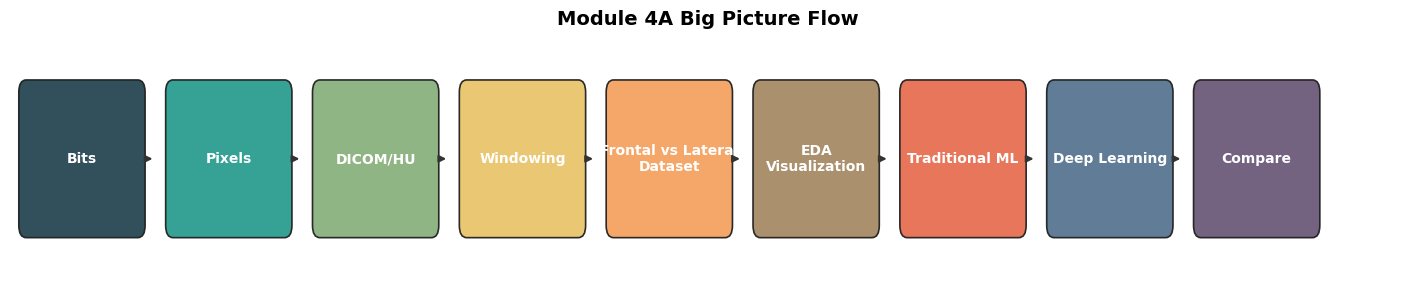

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

pipeline_steps = [
    'Bits',
    'Pixels',
    'DICOM/HU',
    'Windowing',
    'Frontal vs Lateral\nDataset',
    'EDA\nVisualization',
    'Traditional ML',
    'Deep Learning',
    'Compare',
]

colors = ['#264653', '#2A9D8F', '#8AB17D', '#E9C46A', '#F4A261', '#A68A64', '#E76F51', '#577590', '#6D597A']

fig, ax = plt.subplots(figsize=(18, 3.2))
ax.set_xlim(0, 9.5)
ax.set_ylim(0, 1)
ax.axis('off')

for i, (label, color) in enumerate(zip(pipeline_steps, colors), start=1):
    x = i - 0.92
    w = 0.82
    box = FancyBboxPatch(
        (x, 0.2),
        w,
        0.6,
        boxstyle='round,pad=0.02,rounding_size=0.05',
        linewidth=1.2,
        edgecolor='#202020',
        facecolor=color,
        alpha=0.95,
    )
    ax.add_patch(box)
    ax.text(x + w / 2, 0.5, label, ha='center', va='center', color='white', fontsize=10, weight='bold')
    if i < len(pipeline_steps):
        ax.annotate('', xy=(x + w + 0.09, 0.5), xytext=(x + w + 0.01, 0.5), arrowprops=dict(arrowstyle='-|>', lw=1.5, color='#333333'))

ax.set_title('Module 4A Big Picture Flow', fontsize=14, weight='bold', pad=8)
plt.show()


## Helper Functions
Run this once at the start. It configures paths in Google Colab and installs `pydicom` if missing.


In [22]:
import os
import sys
import subprocess
from pathlib import Path


def setup_repo_for_colab(
    repo_url='https://github.com/aaekay/Medical-AI-101.git',
    repo_dir='/content/Medical-AI-101',
    notebook_dir='chapters',
):
    if 'google.colab' not in sys.modules:
        print(f'Local runtime detected. Working directory: {Path.cwd()}')
        return

    repo_path = Path(repo_dir)
    if not repo_path.exists():
        print('Cloning Medical-AI-101 into /content ...')
        subprocess.check_call(['git', 'clone', repo_url, str(repo_path)])

    target = repo_path / notebook_dir
    os.chdir(target)
    print(f'Colab ready. Working directory: {Path.cwd()}')


def ensure_pydicom():
    try:
        import pydicom  # noqa: F401
        print('pydicom is already installed.')
        return True
    except ImportError:
        print('pydicom not found. Installing with pip...')
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pydicom'])
            import pydicom  # noqa: F401
            print('pydicom installed successfully.')
            return True
        except Exception as exc:
            print(f'Could not install pydicom automatically: {exc}')
            print('Please run: pip install pydicom')
            return False


setup_repo_for_colab()
ensure_pydicom()


Local runtime detected. Working directory: /Users/aaekay/Documents/projects/Medical-AI-101/chapters
pydicom is already installed.


True

In [23]:
import io
import base64
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import display

try:
    import ipywidgets as widgets
except ImportError as exc:
    raise ImportError('ipywidgets is required for interactive demos in Module 4A.') from exc

try:
    import pydicom
    from pydicom.data import get_testdata_file
except ImportError:
    pydicom = None
    get_testdata_file = None


## Section 1: Start with 1 Bit (0 or 1)
A 1-bit pixel can store only **two states**:
- `0` -> black
- `1` -> white

This is the simplest visual encoding.


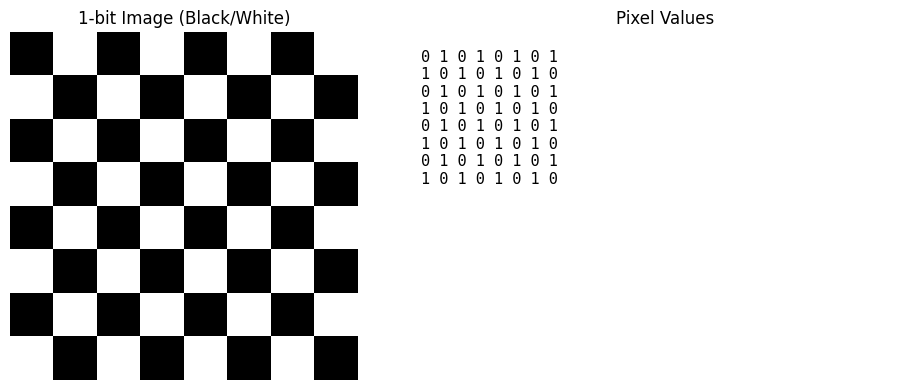

In [24]:
one_bit = np.array([
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
], dtype=np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(one_bit, cmap='gray', vmin=0, vmax=1)
ax[0].set_title('1-bit Image (Black/White)')
ax[0].axis('off')

ax[1].axis('off')
ax[1].set_title('Pixel Values')
val_text = '\n'.join([' '.join(map(str, row)) for row in one_bit])
ax[1].text(0, 0.95, val_text, va='top', family='monospace', fontsize=11)

plt.tight_layout()
plt.show()


## Section 2: 2 Bits Give 4 Intensity Levels
With 2 bits, each pixel can represent `2^2 = 4` levels.
A common mapping to 8-bit display values is:
- `00 -> 0` (black)
- `01 -> 85` (dark gray)
- `10 -> 170` (light gray)
- `11 -> 255` (white)


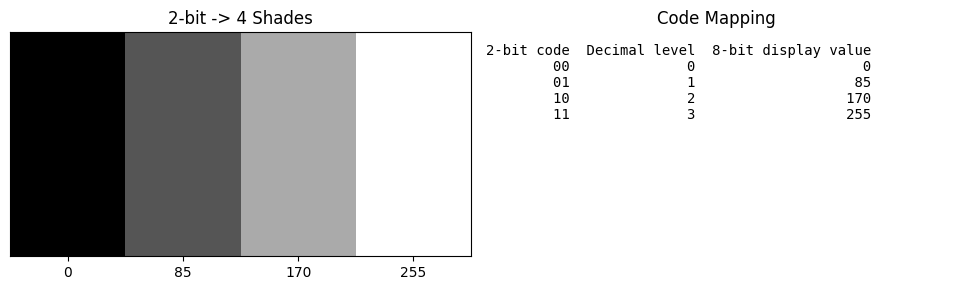

In [25]:
two_bit_levels = np.array([0, 85, 170, 255], dtype=np.uint8)
strip = np.tile(two_bit_levels, (40, 1))

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].imshow(strip, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax[0].set_title('2-bit -> 4 Shades')
ax[0].set_xticks(range(4), ['0', '85', '170', '255'])
ax[0].set_yticks([])

mapping = pd.DataFrame({
    '2-bit code': ['00', '01', '10', '11'],
    'Decimal level': [0, 1, 2, 3],
    '8-bit display value': two_bit_levels,
})
ax[1].axis('off')
ax[1].set_title('Code Mapping')
ax[1].text(0, 0.95, mapping.to_string(index=False), va='top', family='monospace', fontsize=10)

plt.tight_layout()
plt.show()


## Section 3: 4 Bits, 8 Bits, and 16 Bits
As bit depth increases, the number of possible intensity values grows exponentially:
- 4-bit -> `2^4 = 16` levels
- 8-bit -> `2^8 = 256` levels
- 16-bit -> `2^16 = 65,536` levels


,Bit depth,Possible levels (2^bits),Typical use case
0,1,2,Binary masks
1,2,4,Toy examples
2,4,16,Low-depth grayscale
3,8,256,Standard display grayscale / RGB channels
4,16,65536,"Medical imaging source data (CT, MR)"


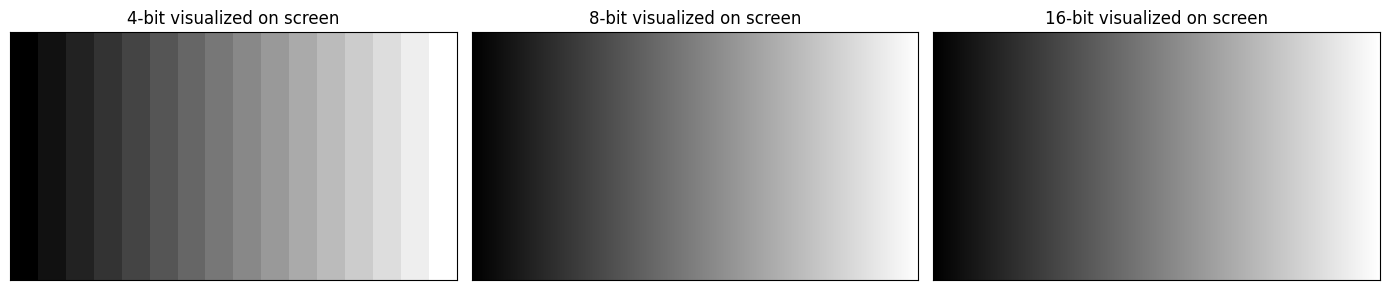

In [26]:
bit_depths = [1, 2, 4, 8, 16]
levels = [2 ** b for b in bit_depths]

summary = pd.DataFrame({
    'Bit depth': bit_depths,
    'Possible levels (2^bits)': levels,
    'Typical use case': [
        'Binary masks',
        'Toy examples',
        'Low-depth grayscale',
        'Standard display grayscale / RGB channels',
        'Medical imaging source data (CT, MR)',
    ]
})
display(summary)

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, bits in zip(axes, [4, 8, 16]):
    vals = np.linspace(0, 255, 2 ** min(bits, 8), dtype=np.uint8)
    band = np.tile(vals, (24, 1))
    ax.imshow(band, cmap='gray', vmin=0, vmax=255, aspect='auto')
    ax.set_title(f'{bits}-bit visualized on screen')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## Section 4: 8-bit Grayscale and Pixel Arrangement
In an 8-bit grayscale image, each pixel is one number from `0` to `255`.
A full image is a 2D matrix of those values.


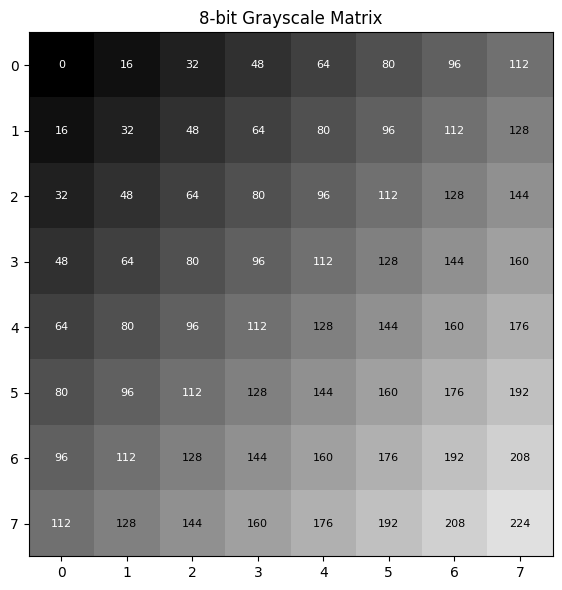

In [27]:
gray_img = np.array([
    [0, 16, 32, 48, 64, 80, 96, 112],
    [16, 32, 48, 64, 80, 96, 112, 128],
    [32, 48, 64, 80, 96, 112, 128, 144],
    [48, 64, 80, 96, 112, 128, 144, 160],
    [64, 80, 96, 112, 128, 144, 160, 176],
    [80, 96, 112, 128, 144, 160, 176, 192],
    [96, 112, 128, 144, 160, 176, 192, 208],
    [112, 128, 144, 160, 176, 192, 208, 224],
], dtype=np.uint8)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax.set_title('8-bit Grayscale Matrix')
ax.set_xticks(range(gray_img.shape[1]))
ax.set_yticks(range(gray_img.shape[0]))

for r in range(gray_img.shape[0]):
    for c in range(gray_img.shape[1]):
        value = gray_img[r, c]
        txt_color = 'white' if value < 120 else 'black'
        ax.text(c, r, str(value), ha='center', va='center', fontsize=8, color=txt_color)

plt.tight_layout()
plt.show()


## Section 5: 8-bit Color (RGB)
A color image usually has **3 channels**:
- Red channel: 0-255
- Green channel: 0-255
- Blue channel: 0-255

Each pixel is an `(R, G, B)` triplet.


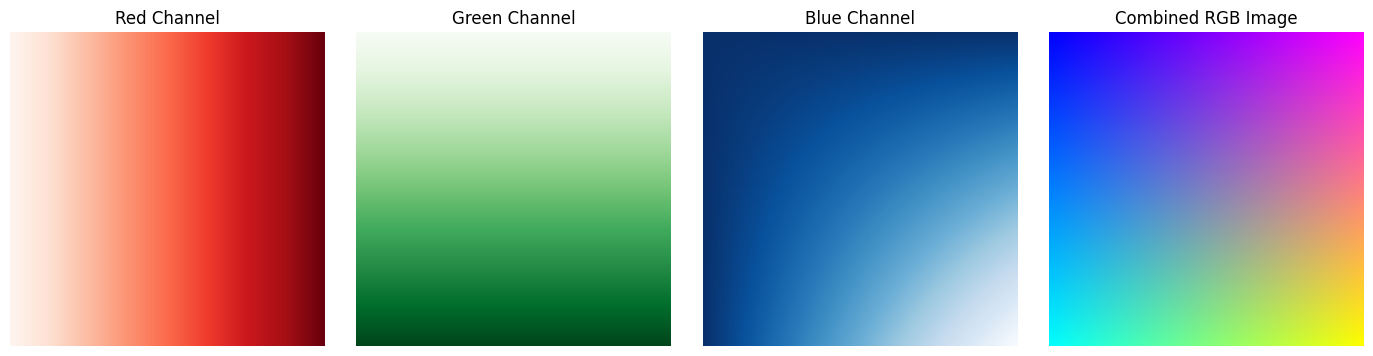

In [28]:
h, w = 128, 128
x = np.linspace(0, 1, w)
y = np.linspace(0, 1, h)
X, Y = np.meshgrid(x, y)

red = (255 * X).astype(np.uint8)
green = (255 * Y).astype(np.uint8)
blue = (255 * (1 - X * Y)).astype(np.uint8)

rgb = np.stack([red, green, blue], axis=-1)

fig, ax = plt.subplots(1, 4, figsize=(14, 3.5))
ax[0].imshow(red, cmap='Reds')
ax[0].set_title('Red Channel')
ax[1].imshow(green, cmap='Greens')
ax[1].set_title('Green Channel')
ax[2].imshow(blue, cmap='Blues')
ax[2].set_title('Blue Channel')
ax[3].imshow(rgb)
ax[3].set_title('Combined RGB Image')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


## Section 6: 16-bit CT Slice in DICOM Format
Medical CT data is often stored with higher dynamic range than normal 8-bit display images.

This section tries to load a sample CT DICOM slice (`CT_small.dcm`) from `pydicom` test data.
If `pydicom` is not installed, run:

`pip install pydicom`


DICOM path: /Users/aaekay/miniconda3/lib/python3.13/site-packages/pydicom/data/test_files/CT_small.dcm
Pixel dtype: int16, shape: (128, 128)
Rescale slope: 1.0, intercept: -1024.0
HU range: min=-896.0, max=1167.0


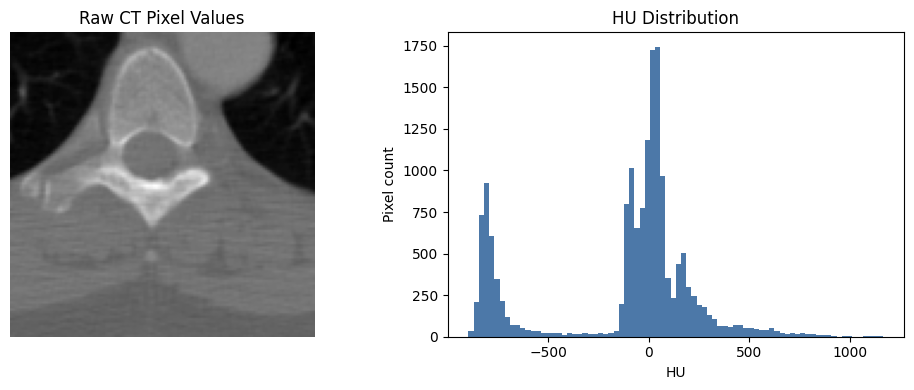

In [29]:
def load_ct_slice_from_dicom(optional_path=None):
    if pydicom is None:
        print('pydicom is not installed. Install with: pip install pydicom')
        return None, None, None

    if optional_path is not None and Path(optional_path).exists():
        dcm_path = str(optional_path)
    else:
        dcm_path = get_testdata_file('CT_small.dcm')

    ds = pydicom.dcmread(dcm_path)
    pixel = ds.pixel_array.astype(np.int16)

    slope = float(getattr(ds, 'RescaleSlope', 1.0))
    intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
    hu = pixel * slope + intercept

    print(f'DICOM path: {dcm_path}')
    print(f'Pixel dtype: {pixel.dtype}, shape: {pixel.shape}')
    print(f'Rescale slope: {slope}, intercept: {intercept}')
    print(f'HU range: min={hu.min():.1f}, max={hu.max():.1f}')

    return ds, pixel, hu

ct_ds, ct_raw, ct_hu = load_ct_slice_from_dicom()

if ct_raw is not None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(ct_raw, cmap='gray')
    ax[0].set_title('Raw CT Pixel Values')
    ax[0].axis('off')

    ax[1].hist(ct_hu.ravel(), bins=80, color='#4c78a8')
    ax[1].set_title('HU Distribution')
    ax[1].set_xlabel('HU')
    ax[1].set_ylabel('Pixel count')

    plt.tight_layout()
    plt.show()


## Section 7: Hounsfield Units and Windowing
Approximate HU anchor points:
- Air: about `-1000`
- Lung tissue: around `-900` to `-500`
- Water: `0`
- Soft tissue: around `30` to `80`
- Bone: `+300` to `+1000` (or higher)

Why windowing?
- CT has many intensity levels (often 16-bit source data).
- Human vision cannot distinguish tens of thousands of gray levels simultaneously.
- Windowing maps a clinically relevant HU range into visible grayscale.


,Material/Tissue,Approx HU
0,Air,-1000
1,Lung,-800
2,Fat,-100
3,Water,0
4,Soft tissue,40
5,Bone (cancellous/cortical),400


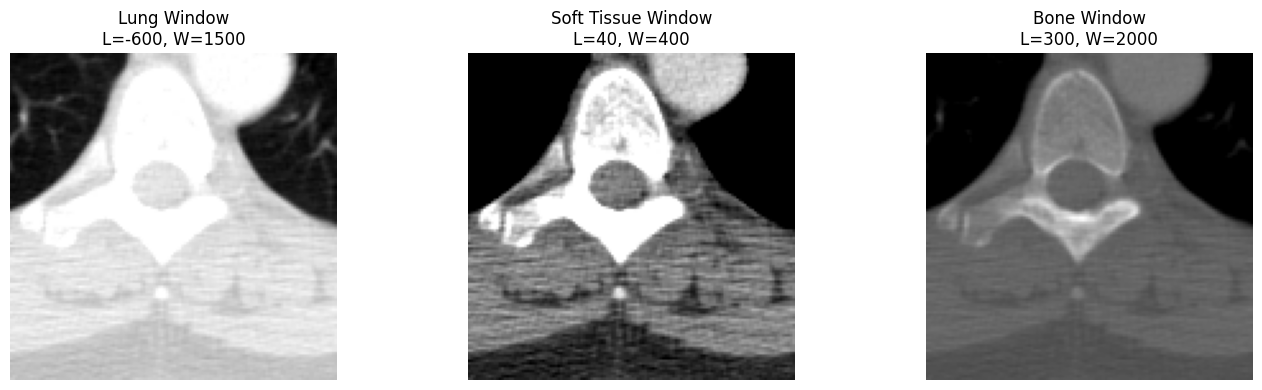

interactive(children=(IntSlider(value=-600, description='Level', max=1000, min=-1000, step=50), IntSlider(valu…

In [30]:
hu_reference = pd.DataFrame([
    {'Material/Tissue': 'Air', 'Approx HU': -1000},
    {'Material/Tissue': 'Lung', 'Approx HU': -800},
    {'Material/Tissue': 'Fat', 'Approx HU': -100},
    {'Material/Tissue': 'Water', 'Approx HU': 0},
    {'Material/Tissue': 'Soft tissue', 'Approx HU': 40},
    {'Material/Tissue': 'Bone (cancellous/cortical)', 'Approx HU': 400},
])
display(hu_reference)


def apply_window(hu_img, level, width):
    low = level - width / 2
    high = level + width / 2
    clipped = np.clip(hu_img, low, high)
    return (clipped - low) / (high - low)

if ct_hu is not None:
    lung = apply_window(ct_hu, level=-600, width=1500)
    bone = apply_window(ct_hu, level=300, width=2000)
    soft = apply_window(ct_hu, level=40, width=400)

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    ax[0].imshow(lung, cmap='gray')
    ax[0].set_title('Lung Window\nL=-600, W=1500')
    ax[1].imshow(soft, cmap='gray')
    ax[1].set_title('Soft Tissue Window\nL=40, W=400')
    ax[2].imshow(bone, cmap='gray')
    ax[2].set_title('Bone Window\nL=300, W=2000')
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

    def interactive_window(level=-600, width=1500):
        img = apply_window(ct_hu, level=level, width=max(width, 1))
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f'Interactive Window: L={level}, W={width}')
        plt.axis('off')
        plt.show()

    widgets.interact(
        interactive_window,
        level=widgets.IntSlider(value=-600, min=-1000, max=1000, step=50, description='Level'),
        width=widgets.IntSlider(value=1500, min=50, max=3000, step=50, description='Width'),
    )
else:
    print('CT data not loaded, so windowing demo is skipped.')


## Section 8: Frontal vs Lateral Chest X-ray Classification Setup
We now connect representation concepts to a practical classification task.

**Task:** classify whether a chest X-ray view is **frontal** or **lateral**.

Default source used in this notebook:
1. Hugging Face Open-I dataset: `https://huggingface.co/datasets/ykumards/open-i`

Why this source?
- Open-I provides paired frontal and lateral views in many studies.
- That makes it easier to build a balanced frontal-vs-lateral teaching dataset.

In this section, the notebook will:
1. Download images from Open-I (if local cache is not enough).
2. Build a balanced `frontal` and `lateral` dataset.
3. Prepare a stratified train/test split for the models below.


In [31]:
def image_from_unknown_payload(payload):
    if payload is None:
        return None

    if isinstance(payload, bytes):
        return Image.open(io.BytesIO(payload)).convert('L')

    if isinstance(payload, str):
        try:
            raw = base64.b64decode(payload)
            return Image.open(io.BytesIO(raw)).convert('L')
        except Exception:
            return None

    if isinstance(payload, dict):
        if 'bytes' in payload and payload['bytes'] is not None:
            return Image.open(io.BytesIO(payload['bytes'])).convert('L')
        if 'path' in payload and payload['path'] and Path(payload['path']).exists():
            return Image.open(payload['path']).convert('L')

    return None


def safe_token(text):
    return ''.join(ch if ch.isalnum() or ch in {'-', '_'} else '_' for ch in str(text))


def resolve_data_root():
    for cand in [Path('../data'), Path('data')]:
        if cand.exists():
            return cand
    fallback = Path('../data')
    fallback.mkdir(parents=True, exist_ok=True)
    return fallback


def ensure_datasets_pkg():
    try:
        import datasets  # noqa: F401
        return True
    except ImportError:
        print('`datasets` not found. Trying one-time install...')
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'datasets'])
            import datasets  # noqa: F401
            print('Installed `datasets` successfully.')
            return True
        except Exception as exc:
            print(f'Could not install `datasets`: {exc}')
            print('Please install manually with: pip install datasets')
            return False


def count_images(folder):
    if not folder.exists():
        return 0
    return len([p for p in folder.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])


def download_openi_frontal_lateral(
    max_per_class=300,
    image_size=96,
    force_redownload=False,
    min_cached_for_fallback=80,
):
    data_root = resolve_data_root()
    out_root = data_root / 'cxr_view_small'
    frontal_dir = out_root / 'frontal'
    lateral_dir = out_root / 'lateral'
    frontal_dir.mkdir(parents=True, exist_ok=True)
    lateral_dir.mkdir(parents=True, exist_ok=True)

    if force_redownload:
        for p in list(frontal_dir.glob('*')) + list(lateral_dir.glob('*')):
            if p.is_file():
                p.unlink()

    n_frontal = count_images(frontal_dir)
    n_lateral = count_images(lateral_dir)

    print('Current cached counts:')
    print(f'- frontal: {n_frontal}')
    print(f'- lateral: {n_lateral}')

    if min(n_frontal, n_lateral) >= max_per_class:
        print('Cached dataset already meets target. Skipping download.')
        return out_root

    if min(n_frontal, n_lateral) >= min_cached_for_fallback:
        print('Cached dataset is below target but still usable. Keeping download optional.')

    if not ensure_datasets_pkg():
        if min(n_frontal, n_lateral) >= min_cached_for_fallback:
            print('Using cached dataset because `datasets` installation failed.')
            return out_root
        return None

    from datasets import load_dataset

    print('\nDownloading Open-I samples from Hugging Face (streaming)...')
    print('This may take a few minutes depending on internet speed.')

    try:
        stream = load_dataset('ykumards/open-i', split='train', streaming=True)
    except Exception as exc:
        print(f'Could not start Open-I stream: {exc}')
        if min(n_frontal, n_lateral) >= min_cached_for_fallback:
            print('Falling back to cached frontal/lateral dataset.')
            return out_root
        return None

    downloaded_frontal = n_frontal
    downloaded_lateral = n_lateral

    for i, ex in enumerate(stream):
        if downloaded_frontal >= max_per_class and downloaded_lateral >= max_per_class:
            break

        uid = safe_token(ex.get('uid', f'row_{i}'))

        if downloaded_frontal < max_per_class:
            f_img = image_from_unknown_payload(ex.get('img_frontal'))
            if f_img is not None:
                out_path = frontal_dir / f'{uid}_{i}_frontal.png'
                f_img.resize((image_size, image_size)).save(out_path)
                downloaded_frontal += 1

        if downloaded_lateral < max_per_class:
            l_img = image_from_unknown_payload(ex.get('img_lateral'))
            if l_img is not None:
                out_path = lateral_dir / f'{uid}_{i}_lateral.png'
                l_img.resize((image_size, image_size)).save(out_path)
                downloaded_lateral += 1

        if (i + 1) % 100 == 0:
            print(f'Processed {i + 1} source rows | frontal={downloaded_frontal} lateral={downloaded_lateral}')

    print('\nDownload step complete:')
    print(f'- frontal: {downloaded_frontal}')
    print(f'- lateral: {downloaded_lateral}')

    if min(downloaded_frontal, downloaded_lateral) == 0:
        if min(n_frontal, n_lateral) >= min_cached_for_fallback:
            print('Download did not improve counts, but cached data is usable. Continuing with cache.')
            return out_root
        print('No usable images found for one or both classes.')
        return None

    return out_root


def build_balanced_manifest(root):
    rows = []
    for label_name, label in [('frontal', 0), ('lateral', 1)]:
        folder = root / label_name
        for p in sorted(folder.iterdir() if folder.exists() else []):
            if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}:
                rows.append({'path': str(p), 'label_name': label_name, 'label': label})

    if not rows:
        return None

    manifest = pd.DataFrame(rows)
    counts = manifest['label_name'].value_counts()
    if len(counts) < 2:
        return None

    per_class = int(counts.min())
    balanced = []
    for label_name in ['frontal', 'lateral']:
        balanced.append(
            manifest[manifest['label_name'] == label_name]
            .sample(n=per_class, random_state=42)
        )

    balanced_manifest = pd.concat(balanced, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
    return balanced_manifest


def load_arrays_from_df(df):
    arrays = []
    labels = []
    for _, row in df.iterrows():
        img = Image.open(row['path']).convert('L')
        arr = np.asarray(img, dtype=np.float32) / 255.0
        arrays.append(arr)
        labels.append(int(row['label']))
    if not arrays:
        return None, None
    return np.stack(arrays), np.array(labels, dtype=np.int64)


TARGET_PER_CLASS = 300  # CPU-friendly target
IMG_SIZE = 96

print('Step 1/3: Download or reuse cached frontal/lateral dataset')
cxr_root = download_openi_frontal_lateral(max_per_class=TARGET_PER_CLASS, image_size=IMG_SIZE, force_redownload=False)

if cxr_root is None:
    print('Dataset download/prep failed. Downstream modeling cells will be skipped.')
    X_train_imgs = y_train_views = X_test_imgs = y_test_views = None
    train_df = test_df = None
else:
    print('\nStep 2/3: Build balanced manifest')
    manifest_df = build_balanced_manifest(cxr_root)

    if manifest_df is None or manifest_df.empty:
        print('Could not build a balanced frontal/lateral manifest.')
        X_train_imgs = y_train_views = X_test_imgs = y_test_views = None
        train_df = test_df = None
    else:
        display(manifest_df.head(8))
        display(manifest_df['label_name'].value_counts().rename('count').to_frame())

        print('\nStep 3/3: Create stratified train/test split')
        train_df, test_df = train_test_split(
            manifest_df,
            test_size=0.25,
            random_state=42,
            stratify=manifest_df['label'],
        )

        X_train_imgs, y_train_views = load_arrays_from_df(train_df)
        X_test_imgs, y_test_views = load_arrays_from_df(test_df)

        print(f'Train images: {len(X_train_imgs)} | Test images: {len(X_test_imgs)}')
        print('Train class balance:')
        print(pd.Series(y_train_views).map({0: 'frontal', 1: 'lateral'}).value_counts())
        print('Test class balance:')
        print(pd.Series(y_test_views).map({0: 'frontal', 1: 'lateral'}).value_counts())


Step 1/3: Download or reuse cached frontal/lateral dataset
Current cached counts:
- frontal: 403
- lateral: 407
Cached dataset already meets target. Skipping download.

Step 2/3: Build balanced manifest


,path,label_name,label
0,../data/cxr_view_small/lateral/39_38_lateral.png,lateral,1
1,../data/cxr_view_small/frontal/298_287_frontal...,frontal,0
2,../data/cxr_view_small/frontal/297_286_frontal...,frontal,0
3,../data/cxr_view_small/frontal/352_340_frontal...,frontal,0
4,../data/cxr_view_small/lateral/385_371_lateral...,lateral,1
5,../data/cxr_view_small/lateral/25_24_lateral.png,lateral,1
6,../data/cxr_view_small/frontal/46_45_frontal.png,frontal,0
7,../data/cxr_view_small/frontal/183_177_frontal...,frontal,0


,count
label_name,
lateral,403
frontal,403



Step 3/3: Create stratified train/test split
Train images: 604 | Test images: 202
Train class balance:
lateral    302
frontal    302
Name: count, dtype: int64
Test class balance:
frontal    101
lateral    101
Name: count, dtype: int64


## Section 9: Pre-Model EDA - Are Frontal and Lateral Different?
Before training Logistic Regression, we first check simple visual/statistical differences:
- Do frontal and lateral images differ in **mean pixel intensity**?
- Do they differ in **pixel intensity spread (standard deviation)**?
- Do class-average images show obvious geometric differences?


Summary statistics by view:


,mean_intensity,std_intensity,center_intensity
view,,,
frontal,0.6202,0.2289,0.6105
lateral,0.5329,0.2919,0.5993


/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_80625/2856109940.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(


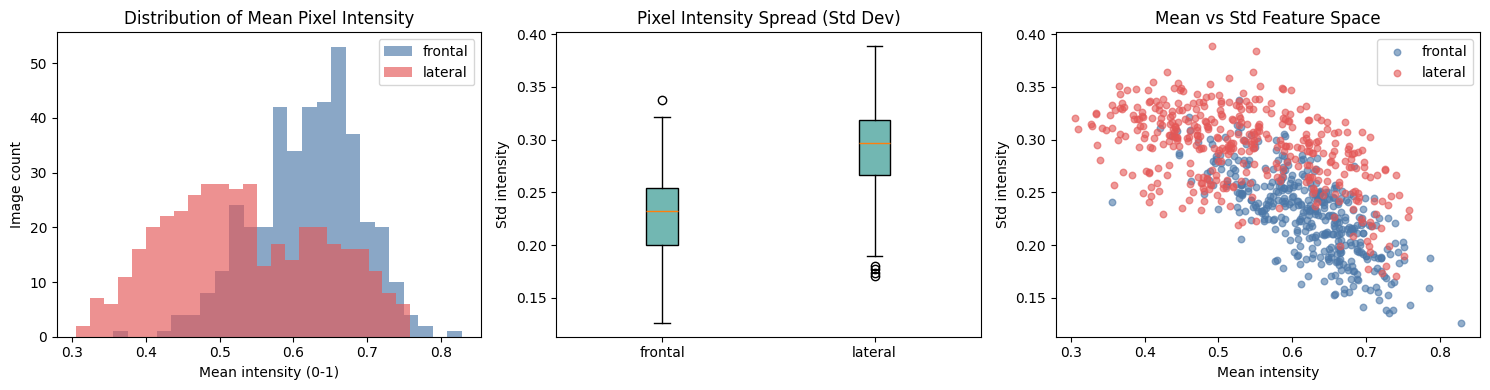

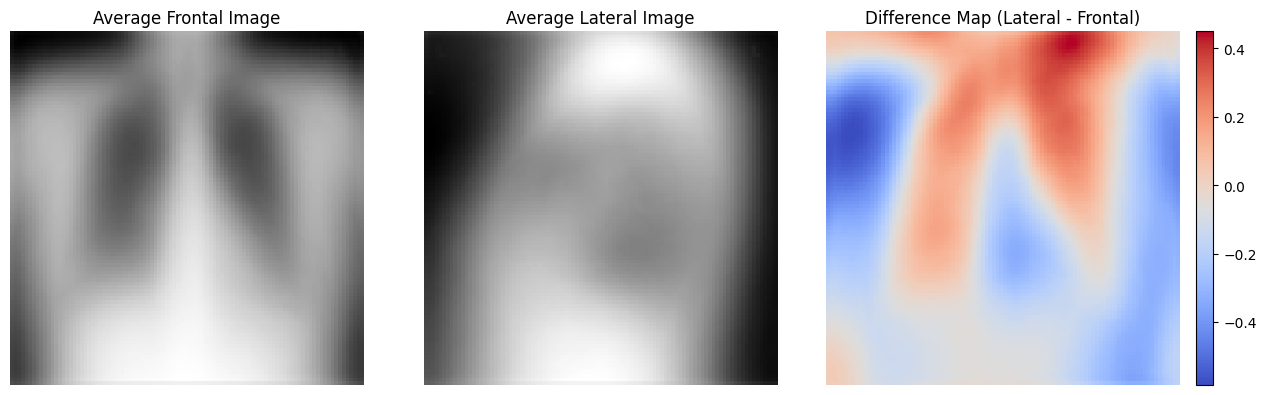

Observation prompt: Do these simple plots suggest that frontal and lateral views are separable before modeling?


In [32]:
if X_train_imgs is None or X_test_imgs is None:
    print('Skipping EDA because dataset preparation did not complete.')
else:
    X_all = np.concatenate([X_train_imgs, X_test_imgs], axis=0)
    y_all = np.concatenate([y_train_views, y_test_views], axis=0)

    mean_intensity = X_all.mean(axis=(1, 2))
    std_intensity = X_all.std(axis=(1, 2))

    # Center patch intensity can capture projection-specific central brightness patterns.
    h, w = X_all.shape[1], X_all.shape[2]
    center_patch = X_all[:, h // 4 : 3 * h // 4, w // 4 : 3 * w // 4]
    center_intensity = center_patch.mean(axis=(1, 2))

    stats_df = pd.DataFrame({
        'label': y_all,
        'view': pd.Series(y_all).map({0: 'frontal', 1: 'lateral'}),
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'center_intensity': center_intensity,
    })

    print('Summary statistics by view:')
    display(stats_df.groupby('view')[['mean_intensity', 'std_intensity', 'center_intensity']].mean().round(4))

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    frontal_mask = stats_df['label'] == 0
    lateral_mask = stats_df['label'] == 1

    ax[0].hist(stats_df.loc[frontal_mask, 'mean_intensity'], bins=24, alpha=0.65, label='frontal', color='#4c78a8')
    ax[0].hist(stats_df.loc[lateral_mask, 'mean_intensity'], bins=24, alpha=0.65, label='lateral', color='#e45756')
    ax[0].set_title('Distribution of Mean Pixel Intensity')
    ax[0].set_xlabel('Mean intensity (0-1)')
    ax[0].set_ylabel('Image count')
    ax[0].legend()

    ax[1].boxplot(
        [stats_df.loc[frontal_mask, 'std_intensity'], stats_df.loc[lateral_mask, 'std_intensity']],
        labels=['frontal', 'lateral'],
        patch_artist=True,
        boxprops=dict(facecolor='#72b7b2')
    )
    ax[1].set_title('Pixel Intensity Spread (Std Dev)')
    ax[1].set_ylabel('Std intensity')

    ax[2].scatter(
        stats_df.loc[frontal_mask, 'mean_intensity'],
        stats_df.loc[frontal_mask, 'std_intensity'],
        alpha=0.6,
        s=22,
        label='frontal',
        color='#4c78a8',
    )
    ax[2].scatter(
        stats_df.loc[lateral_mask, 'mean_intensity'],
        stats_df.loc[lateral_mask, 'std_intensity'],
        alpha=0.6,
        s=22,
        label='lateral',
        color='#e45756',
    )
    ax[2].set_title('Mean vs Std Feature Space')
    ax[2].set_xlabel('Mean intensity')
    ax[2].set_ylabel('Std intensity')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    frontal_mean_img = X_all[y_all == 0].mean(axis=0)
    lateral_mean_img = X_all[y_all == 1].mean(axis=0)
    diff_img = lateral_mean_img - frontal_mean_img

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    ax[0].imshow(frontal_mean_img, cmap='gray')
    ax[0].set_title('Average Frontal Image')
    ax[0].axis('off')

    ax[1].imshow(lateral_mean_img, cmap='gray')
    ax[1].set_title('Average Lateral Image')
    ax[1].axis('off')

    im = ax[2].imshow(diff_img, cmap='coolwarm')
    ax[2].set_title('Difference Map (Lateral - Frontal)')
    ax[2].axis('off')
    fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print('Observation prompt: Do these simple plots suggest that frontal and lateral views are separable before modeling?')


## Section 10: Traditional ML Baseline (Logistic Regression)
We flatten each image into a feature vector and train a simple Logistic Regression classifier.
This is a fast baseline for the **frontal vs lateral** task.


Logistic Regression accuracy: 1.000

Classification report:
              precision    recall  f1-score   support

     frontal       1.00      1.00      1.00       101
     lateral       1.00      1.00      1.00       101

    accuracy                           1.00       202
   macro avg       1.00      1.00      1.00       202
weighted avg       1.00      1.00      1.00       202



/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


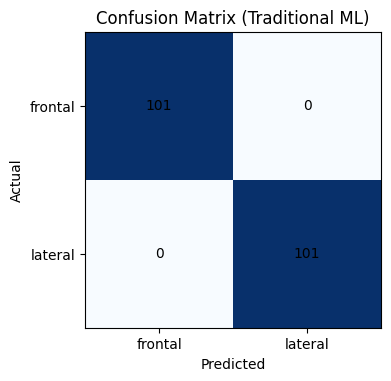

In [33]:
if X_train_imgs is None or X_test_imgs is None:
    print('Skipping ML baseline because dataset preparation did not complete.')
    frontal_ml_metrics = None
else:
    X_train_flat = X_train_imgs.reshape(len(X_train_imgs), -1)
    X_test_flat = X_test_imgs.reshape(len(X_test_imgs), -1)

    ml_model = LogisticRegression(max_iter=1200, solver='liblinear', random_state=42)
    ml_model.fit(X_train_flat, y_train_views)

    y_pred = ml_model.predict(X_test_flat)
    frontal_ml_acc = accuracy_score(y_test_views, y_pred)
    cm = confusion_matrix(y_test_views, y_pred)

    frontal_ml_metrics = {
        'accuracy': frontal_ml_acc,
        'model': 'Logistic Regression',
        'task': 'frontal_vs_lateral',
    }

    print(f'Logistic Regression accuracy: {frontal_ml_acc:.3f}')
    print('\nClassification report:')
    print(classification_report(y_test_views, y_pred, target_names=['frontal', 'lateral']))

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap='Blues')
    ax.set_title('Confusion Matrix (Traditional ML)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['frontal', 'lateral'])
    ax.set_yticks([0, 1], ['frontal', 'lateral'])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()


## Section 11: Deep Learning Baseline (Compact CNN)
Now we train a small CNN directly on pixel grids for the same **frontal vs lateral** split.
Even with a compact architecture, this demonstrates why deep learning is natural for image tasks.


Epoch 01 | train_loss=0.2155 | train_acc=0.914 | test_acc=0.970
Epoch 02 | train_loss=0.0432 | train_acc=0.987 | test_acc=0.995
Epoch 03 | train_loss=0.0141 | train_acc=0.990 | test_acc=0.990
Epoch 04 | train_loss=0.0121 | train_acc=0.995 | test_acc=0.990


,epoch,train_loss,train_acc,test_acc
0,1,0.215474,0.913907,0.970297
1,2,0.043184,0.986755,0.995050
2,3,0.014123,0.990066,0.990099
3,4,0.012051,0.995033,0.990099


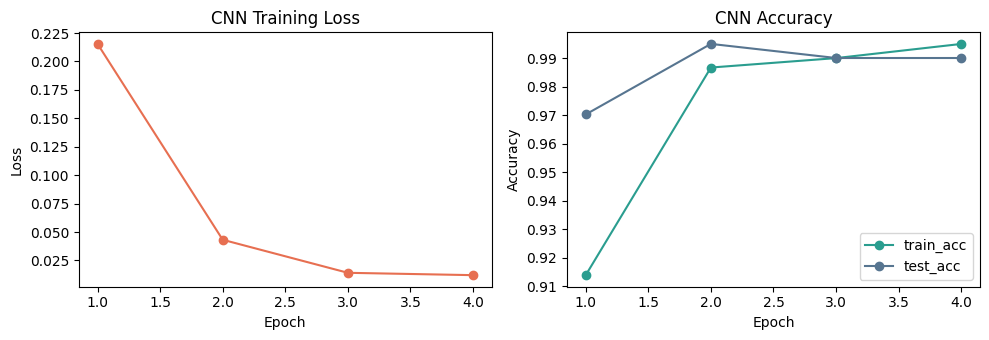

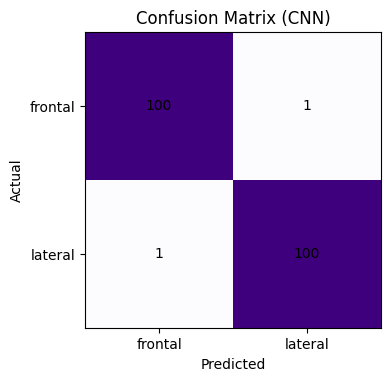

In [34]:
if X_train_imgs is None or X_test_imgs is None:
    print('Skipping CNN baseline because dataset preparation did not complete.')
    frontal_cnn_metrics = None
else:
    X_train_t = torch.tensor(X_train_imgs[:, None, :, :], dtype=torch.float32)
    X_test_t = torch.tensor(X_test_imgs[:, None, :, :], dtype=torch.float32)
    y_train_t = torch.tensor(y_train_views, dtype=torch.long)
    y_test_t = torch.tensor(y_test_views, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    class TinyViewCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32 * 24 * 24, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
            )

        def forward(self, x):
            x = self.features(x)
            return self.classifier(x)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TinyViewCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    history = []
    epochs = 4

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = logits.argmax(dim=1)
                test_correct += (preds == yb).sum().item()
                test_total += xb.size(0)
                all_preds.extend(preds.cpu().numpy())

        test_acc = test_correct / test_total
        history.append({'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'test_acc': test_acc})
        print(f'Epoch {epoch:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}')

    hist_df = pd.DataFrame(history)
    display(hist_df)

    frontal_cnn_acc = float(hist_df['test_acc'].iloc[-1])
    frontal_cnn_metrics = {
        'accuracy': frontal_cnn_acc,
        'model': 'Tiny CNN',
        'task': 'frontal_vs_lateral',
    }

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    ax[0].plot(hist_df['epoch'], hist_df['train_loss'], marker='o', color='#e76f51')
    ax[0].set_title('CNN Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(hist_df['epoch'], hist_df['train_acc'], marker='o', label='train_acc', color='#2a9d8f')
    ax[1].plot(hist_df['epoch'], hist_df['test_acc'], marker='o', label='test_acc', color='#577590')
    ax[1].set_title('CNN Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    cm_dl = confusion_matrix(y_test_views, np.array(all_preds))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm_dl, cmap='Purples')
    ax.set_title('Confusion Matrix (CNN)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['frontal', 'lateral'])
    ax.set_yticks([0, 1], ['frontal', 'lateral'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm_dl[i, j]), ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()


## Section 12: Compare the Baselines
Use these questions as a mini discussion:
1. Did pre-model EDA already show visible frontal-vs-lateral separation?
2. Which model performed better on your dataset split?
3. Did the classical model already do well, or did CNN add clear value?
4. If performance is poor, is it because of low data volume, label noise, or preprocessing choices?
5. How might mixing PA and AP views inside the frontal class affect results?


,Model,Accuracy
0,Logistic Regression,1.0000
1,Tiny CNN,0.9901


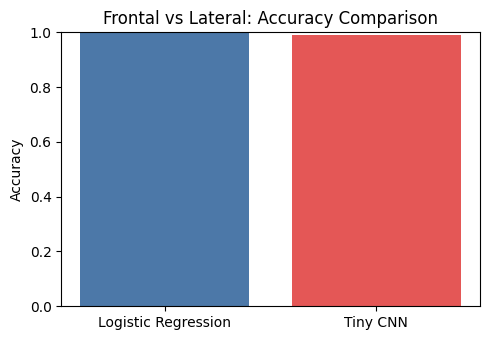

In this run, Logistic Regression is as good as or better than the CNN for frontal-vs-lateral classification.
Teaching point: simple geometric projection differences can often be captured by traditional ML baselines.


In [35]:
if frontal_ml_metrics is None or frontal_cnn_metrics is None:
    print('Run both frontal-vs-lateral model cells first to compare metrics.')
else:
    frontal_compare_df = pd.DataFrame([
        {'Model': 'Logistic Regression', 'Accuracy': frontal_ml_metrics['accuracy']},
        {'Model': 'Tiny CNN', 'Accuracy': frontal_cnn_metrics['accuracy']},
    ])
    display(frontal_compare_df.round(4))

    plt.figure(figsize=(5, 3.5))
    plt.bar(frontal_compare_df['Model'], frontal_compare_df['Accuracy'], color=['#4c78a8', '#e45756'])
    plt.ylim(0.0, 1.0)
    plt.title('Frontal vs Lateral: Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    if frontal_ml_metrics['accuracy'] >= frontal_cnn_metrics['accuracy']:
        print('In this run, Logistic Regression is as good as or better than the CNN for frontal-vs-lateral classification.')
        print('Teaching point: simple geometric projection differences can often be captured by traditional ML baselines.')
    else:
        print('In this run, the CNN outperformed Logistic Regression.')
        print('Teaching point: results can vary with data volume, preprocessing, and training budget.')


## Checkpoint Wrap-up: Frontal vs Lateral Task
- Images are numerical matrices; bit depth controls how much intensity information each pixel can store.
- 8-bit is common for display, but medical modalities like CT often start with much richer 16-bit ranges.
- Hounsfield Units and windowing convert raw CT values into clinically useful visual views.
- Frontal-vs-lateral classification can be a task where traditional ML is already very competitive.
- We now move to a harder pathology task: pneumothorax detection.


## Section 13: New Clinical Problem - Pneumothorax
**Clinical question:** Can we detect pneumothorax on chest X-ray?

Why this is harder than frontal-vs-lateral:
- Pneumothorax can be subtle and often localized.
- Global brightness/shape statistics may not be enough.
- We care about sensitivity because false negatives can be clinically harmful.

In the next sections, we will run two approaches on the same split:
1. Traditional ML (handcrafted HOG/intensity features + Logistic Regression)
2. Deep Learning (transfer learning with ResNet18)


## Section 14: Download and Prepare SIIM Pneumothorax Data (Colab-Friendly)
This section follows the planned protocol:
- Source (default): KaggleHub dataset mirror `jesperdramsch/siim-acr-pneumothorax-segmentation-data`
- Build classification labels from `train-rle.csv`
- Construct balanced splits (target per class):
  - train: 1000 positive + 1000 negative
  - val: 300 positive + 300 negative
  - test: 300 positive + 300 negative

If full targets are not available locally, the notebook will scale down while preserving class balance.

### Default dataset download path used in this notebook
```python
import kagglehub
path = kagglehub.dataset_download("jesperdramsch/siim-acr-pneumothorax-segmentation-data")
print(path)
```

### Notes
- The notebook first tries KaggleHub.
- If that fails, it optionally falls back to Kaggle competition download.
- Legacy Kaggle credentials are still supported as fallback.


In [36]:
import os
import sys
import shutil
import subprocess
import zipfile
from pathlib import Path


def ensure_pkg(module_name, pip_name=None):
    pip_name = pip_name or module_name
    try:
        __import__(module_name)
        return True
    except Exception:
        print(f'Installing missing dependency: {pip_name}')
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pip_name])
            __import__(module_name)
            return True
        except Exception as exc:
            print(f'Could not install {pip_name}: {exc}')
            return False


def module_exists(module_name):
    try:
        import importlib.util
        return importlib.util.find_spec(module_name) is not None
    except Exception:
        return False


def missing_kagglesdk_modules():
    required = [
        'kagglesdk.kaggle_client',
        'kagglesdk.kaggle_env',
        'kagglesdk.kaggle_http_client',
    ]
    return [m for m in required if not module_exists(m)]


def clear_kaggle_modules_cache():
    # Remove stale partially-imported modules after pip reinstall.
    for name in list(sys.modules.keys()):
        if name == 'kaggle' or name.startswith('kaggle.') or name.startswith('kagglehub') or name.startswith('kagglesdk'):
            sys.modules.pop(name, None)


def repair_kaggle_stack(reason=''):
    if reason:
        print(f'Repairing Kaggle package stack ({reason})...')

    cmd = [
        sys.executable,
        '-m',
        'pip',
        'install',
        '-q',
        '--upgrade',
        '--force-reinstall',
        '--no-cache-dir',
        'kagglesdk',
        'kagglehub',
        'kaggle',
    ]

    try:
        subprocess.check_call(cmd)
    except Exception as exc:
        print(f'Kaggle package repair failed: {exc}')
        return False

    clear_kaggle_modules_cache()

    missing_after = missing_kagglesdk_modules()
    if missing_after:
        print('Kaggle package repair incomplete. Missing:', ', '.join(missing_after))
        return False

    print('Kaggle package stack repaired.')
    return True


def ensure_kagglehub_ready():
    try:
        import kagglehub  # noqa: F401
        return True
    except Exception as exc:
        print(f'kagglehub import failed: {exc}')

    # Detect common breakage where kaggle/kagglehub install but kagglesdk modules are missing.
    missing = missing_kagglesdk_modules()
    if missing:
        print('Detected incomplete kagglesdk install:', ', '.join(missing))
        if repair_kaggle_stack('missing kagglesdk modules for kagglehub'):
            try:
                import kagglehub  # noqa: F401
                return True
            except Exception as exc:
                print(f'kagglehub import still failing after repair: {exc}')

    clear_kaggle_modules_cache()

    print('Installing missing dependency: kagglehub')
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '--upgrade', '--no-cache-dir', 'kagglehub'])
        import kagglehub  # noqa: F401
        return True
    except Exception as exc:
        print(f'Could not install kagglehub: {exc}')
        return False


def kaggle_base_cmd():
    if shutil.which('kaggle'):
        return ['kaggle']

    if module_exists('kaggle'):
        return [sys.executable, '-m', 'kaggle']

    return None


def ensure_kaggle_cli(prefer_upgrade=True):
    if prefer_upgrade:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '--upgrade', '--no-cache-dir', 'kaggle'])
        except Exception as exc:
            print(f'Could not upgrade kaggle package: {exc}')

    missing = missing_kagglesdk_modules()
    if missing:
        print('Detected incomplete kagglesdk install:', ', '.join(missing))
        if not repair_kaggle_stack('missing kagglesdk modules for kaggle cli'):
            return False

    cmd = kaggle_base_cmd()
    if cmd is not None:
        return True

    print('Installing missing dependency: kaggle')
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '--no-cache-dir', 'kaggle'])
    except Exception as exc:
        print(f'Could not install kaggle: {exc}')
        return False

    cmd = kaggle_base_cmd()
    if cmd is None:
        print('Kaggle CLI is still not available after installation.')
        return False

    return True


def kaggle_client_supports_token_env():
    candidates = []
    for base in [Path(s) for s in sys.path if s]:
        cand = base / 'kaggle' / 'api' / 'kaggle_api_extended.py'
        if cand.exists():
            candidates.append(cand)

    for cand in candidates:
        try:
            txt = cand.read_text(errors='ignore')
        except Exception:
            continue
        if 'KAGGLE_API_TOKEN' in txt:
            return True

    return False


_ = ensure_pkg('skimage', 'scikit-image')
_ = ensure_pkg('torchvision', 'torchvision')
_ = ensure_pkg('pydicom', 'pydicom')

DATA_ROOT = resolve_data_root()
SIIM_ROOT = DATA_ROOT / 'siim_pneumothorax'
SIIM_ROOT.mkdir(parents=True, exist_ok=True)


def find_first(root, patterns):
    for pattern in patterns:
        for match in root.rglob(pattern):
            return match
    return None


def locate_siim_files(root):
    rle_csv = find_first(root, ['train-rle.csv', '*train*rle*.csv', '*rle*.csv'])
    any_dcm = find_first(root, ['*.dcm'])
    return rle_csv, any_dcm


def resolve_kagglehub_roots(hub_path):
    candidates = []

    if hub_path.is_file():
        candidates.append(hub_path.parent)
    candidates.append(hub_path)

    versions_dir = hub_path / 'versions'
    if versions_dir.exists() and versions_dir.is_dir():
        version_dirs = [p for p in versions_dir.iterdir() if p.is_dir()]
        version_dirs.sort(key=lambda p: p.name, reverse=True)
        candidates = version_dirs + candidates

    uniq = []
    seen = set()
    for p in candidates:
        key = str(p.resolve()) if p.exists() else str(p)
        if key not in seen:
            seen.add(key)
            uniq.append(p)

    return uniq


def has_siim_payload(root):
    rle_csv, any_dcm = locate_siim_files(root)
    return rle_csv is not None and any_dcm is not None


def extract_candidate_archives(source_root, unpack_root):
    archive_map = {}
    for pattern in ['*.zip', '*.archive']:
        for p in source_root.rglob(pattern):
            archive_map[str(p)] = p

    archives = [archive_map[k] for k in sorted(archive_map)]
    if not archives:
        return False

    print(f'Found {len(archives)} archive file(s) in KaggleHub path; extracting...')
    unpack_root.mkdir(parents=True, exist_ok=True)
    extracted_any = False

    for arc in archives:
        out_dir = unpack_root / arc.stem
        out_dir.mkdir(parents=True, exist_ok=True)
        try:
            with zipfile.ZipFile(arc, 'r') as zf:
                zf.extractall(out_dir)
                extracted_any = True
        except Exception as exc:
            print(f'Could not unzip {arc}: {exc}')

    return extracted_any


def prepare_from_kagglehub(cache_root):
    if not ensure_kagglehub_ready():
        return None

    try:
        import kagglehub
    except Exception as exc:
        print(f'kagglehub import failed: {exc}')
        return None

    print('Trying KaggleHub dataset mirror...')
    dataset_id = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'

    def _download(force=False):
        try:
            if force:
                return Path(kagglehub.dataset_download(dataset_id, force_download=True))
            return Path(kagglehub.dataset_download(dataset_id))
        except TypeError:
            # Backward compatibility with older kagglehub versions.
            return Path(kagglehub.dataset_download(dataset_id))

    try:
        hub_path = _download(force=False)
    except Exception as exc:
        print(f'KaggleHub dataset download failed: {exc}')
        return None

    print(f'KaggleHub path: {hub_path}')

    for candidate in resolve_kagglehub_roots(hub_path):
        if has_siim_payload(candidate):
            print(f'Found SIIM files in KaggleHub cache: {candidate}')
            return candidate

    source_root = hub_path if hub_path.is_dir() else hub_path.parent
    archive_exists = find_first(source_root, ['*.archive', '*.zip']) is not None
    if archive_exists:
        print('KaggleHub cache contains archive files; retrying with forced download...')
        try:
            forced_path = _download(force=True)
            print(f'KaggleHub forced path: {forced_path}')
            for candidate in resolve_kagglehub_roots(forced_path):
                if has_siim_payload(candidate):
                    print(f'Found SIIM files after force download: {candidate}')
                    return candidate
            source_root = forced_path if forced_path.is_dir() else forced_path.parent
        except Exception as exc:
            print(f'Force download retry failed: {exc}')

    unzip_root = cache_root / 'kagglehub_unpack'
    if extract_candidate_archives(source_root, unzip_root) and has_siim_payload(unzip_root):
        print('Found SIIM files after extracting KaggleHub archives.')
        return unzip_root

    print('KaggleHub path did not contain expected SIIM payload (train-rle.csv + DICOM files).')
    return None


def read_colab_secret(name):
    try:
        from google.colab import userdata
        value = userdata.get(name)
        if value is None:
            return ''
        return str(value).strip()
    except Exception:
        return ''


def read_token_file(path):
    if not path.exists():
        return ''
    try:
        token = path.read_text().strip()
        return token
    except Exception:
        return ''


def kaggle_credentials_ready():
    token = read_colab_secret('KAGGLE_API_TOKEN') or read_colab_secret('kaggle_api_token')
    if not token:
        token = os.environ.get('KAGGLE_API_TOKEN', '').strip()

    if not token:
        token_path_candidates = [
            Path.home() / '.kaggle' / 'access_token',
            Path.home() / '.kaggle' / 'access_token.txt',
        ]
        for tp in token_path_candidates:
            token = read_token_file(tp)
            if token:
                print(f'Using Kaggle API token from {tp}')
                break

    if token:
        os.environ['KAGGLE_API_TOKEN'] = token

        token_dir = Path.home() / '.kaggle'
        token_dir.mkdir(parents=True, exist_ok=True)
        for tp in [token_dir / 'access_token', token_dir / 'access_token.txt']:
            try:
                tp.write_text(token)
                tp.chmod(0o600)
            except Exception:
                pass

        os.environ['KAGGLE_AUTH_SOURCE'] = 'token'

        if not kaggle_client_supports_token_env():
            user = read_colab_secret('KAGGLE_USERNAME') or read_colab_secret('kaggle_username')
            if not user:
                user = os.environ.get('KAGGLE_USERNAME', '').strip()

            if user:
                os.environ['KAGGLE_USERNAME'] = user
                os.environ['KAGGLE_KEY'] = token
                try:
                    legacy_path = token_dir / 'kaggle.json'
                    legacy_path.write_text('{"username":"' + user + '","key":"' + token + '"}')
                    legacy_path.chmod(0o600)
                    print('Legacy compatibility enabled: built ~/.kaggle/kaggle.json from KAGGLE_USERNAME + KAGGLE_API_TOKEN.')
                except Exception:
                    pass
            else:
                print('Detected legacy kaggle-api runtime; token-only auth may fail without KAGGLE_USERNAME.')
                print('If download fails, add Colab Secret KAGGLE_USERNAME or upload kaggle.json.')

        print('Using Kaggle token-only credentials (KAGGLE_API_TOKEN).')
        return True

    user = read_colab_secret('KAGGLE_USERNAME') or read_colab_secret('kaggle_username')
    key = read_colab_secret('KAGGLE_KEY') or read_colab_secret('kaggle_key')

    if not user:
        user = os.environ.get('KAGGLE_USERNAME', '').strip()
    if not key:
        key = os.environ.get('KAGGLE_KEY', '').strip()

    if user and key:
        os.environ['KAGGLE_USERNAME'] = user
        os.environ['KAGGLE_KEY'] = key
        os.environ['KAGGLE_AUTH_SOURCE'] = 'legacy'
        print('Using legacy Kaggle credentials from secrets/environment variables.')
        return True

    token_path = Path.home() / '.kaggle' / 'kaggle.json'
    if token_path.exists():
        token_path.chmod(0o600)
        os.environ['KAGGLE_AUTH_SOURCE'] = 'legacy'
        print('Using legacy Kaggle credentials from ~/.kaggle/kaggle.json')
        return True

    colab_candidate = Path('/content/kaggle.json')
    if colab_candidate.exists():
        token_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(colab_candidate, token_path)
        token_path.chmod(0o600)
        os.environ['KAGGLE_AUTH_SOURCE'] = 'legacy'
        print('Copied /content/kaggle.json -> ~/.kaggle/kaggle.json')
        return True

    return False


def ensure_siim_dataset(root):
    rle_csv, any_dcm = locate_siim_files(root)
    if rle_csv is not None and any_dcm is not None:
        print(f'Using existing SIIM data at: {root}')
        return root

    print('SIIM dataset not found locally. Trying KaggleHub dataset mirror...')
    hub_root = prepare_from_kagglehub(root)
    if hub_root is not None:
        return hub_root

    print('KaggleHub path failed. Attempting Kaggle competition download...')

    if not kaggle_credentials_ready():
        print('Kaggle credentials not found. Set KAGGLE_API_TOKEN (recommended) or use legacy kaggle.json/user+key.')
        print('In Colab, you can upload /content/kaggle.json and rerun this cell.')
        return None

    if not ensure_kaggle_cli(prefer_upgrade=True):
        print('Kaggle CLI install failed. Cannot use competition fallback in this runtime.')
        return None

    kaggle_cmd = kaggle_base_cmd()
    if kaggle_cmd is None:
        print('Kaggle CLI is unavailable. Install `kaggle` package and rerun.')
        return None

    candidate_cmds = [
        kaggle_cmd + [
            'competitions',
            'download',
            'siim-acr-pneumothorax-segmentation',
            '--path',
            str(root),
        ],
        kaggle_cmd + [
            'competitions',
            'download',
            '-c',
            'siim-acr-pneumothorax-segmentation',
            '-p',
            str(root),
        ],
    ]

    download_ok = False
    last_stdout = ''
    last_stderr = ''

    for idx, cmd_download in enumerate(candidate_cmds):
        result = subprocess.run(cmd_download, capture_output=True, text=True)
        if result.returncode == 0:
            download_ok = True
            if result.stdout.strip():
                print(result.stdout.strip())
            break

        last_stdout = (result.stdout or '').strip()
        last_stderr = (result.stderr or '').strip()

        if idx == 0:
            print('Primary Kaggle download command failed; trying legacy flag format...')

    if not download_ok:
        if last_stdout:
            print('Kaggle stdout:')
            print(last_stdout)
        if last_stderr:
            print('Kaggle stderr:')
            print(last_stderr)

        combined = (last_stdout + "\n" + last_stderr).lower()
        if 'accept the competition rules' in combined or 'competition rules' in combined:
            print('You likely need to accept the competition rules on Kaggle website first.')
            print('Open the SIIM competition page, accept rules, then rerun this cell.')

        if 'cannot import name' in combined and 'kagglesdk' in combined:
            print('Detected a broken kaggle/kagglesdk install while running Kaggle CLI.')
            print('Try rerunning this cell once; the auto-repair path should reinstall kaggle stack.')

        if 'could not find kaggle.json' in combined and os.environ.get('KAGGLE_AUTH_SOURCE') == 'token':
            print('This runtime appears to use legacy kaggle-api auth and did not accept token-only credentials.')
            print('Add Colab Secret KAGGLE_USERNAME (with KAGGLE_API_TOKEN), or upload kaggle.json, then rerun.')

        return None

    zip_files = sorted(root.glob('*.zip'))
    for z in zip_files:
        print(f'Unzipping {z.name} ...')
        try:
            subprocess.check_call(['unzip', '-o', str(z), '-d', str(root)])
        except Exception as exc:
            print(f'Failed to unzip {z.name}: {exc}')

    rle_csv, any_dcm = locate_siim_files(root)
    if rle_csv is None or any_dcm is None:
        print('Could not locate train-rle.csv and DICOM files after download.')
        return None

    print(f'SIIM data prepared at: {root}')
    return root


def _norm_col(col_name):
    return str(col_name).strip().lstrip('﻿').lower().replace(' ', '').replace('_', '')


def _clean_image_id(value):
    s = str(value).strip()
    if s.lower().endswith('.dcm'):
        s = s[:-4]
    return s


def build_classification_manifest(root):
    rle_csv = find_first(root, ['train-rle.csv'])
    if rle_csv is None:
        return None

    rle_df = pd.read_csv(rle_csv)
    if rle_df.empty:
        print(f'RLE table is empty: {rle_csv}')
        return None

    col_norm = {c: _norm_col(c) for c in rle_df.columns}
    norm_to_col = {}
    for c, n in col_norm.items():
        norm_to_col.setdefault(n, []).append(c)

    def pick_col(candidates):
        for cand in candidates:
            if cand in norm_to_col:
                return norm_to_col[cand][0]
        return None

    image_col = pick_col(['imageid', 'image', 'id', 'dicomid', 'sopinstanceuid'])
    encoded_col = pick_col(['encodedpixels', 'encodedpixel', 'maskrle', 'rle'])
    target_col = pick_col(['target', 'label', 'class', 'ispositive', 'pneumothorax'])

    if image_col is None:
        print('Could not find image-id column in train-rle.csv')
        print('Available columns:', list(rle_df.columns))
        return None

    # Determine positive/negative label column robustly across schema variants.
    if encoded_col is not None:
        raw = rle_df[encoded_col].astype(str).str.strip().str.lower()
        is_positive = ~raw.isin(['-1', '', 'nan', 'none', 'null', '0'])
        label_source = f'encoded_rle:{encoded_col}'
    elif target_col is not None:
        numeric_target = pd.to_numeric(rle_df[target_col], errors='coerce')
        if numeric_target.notna().any():
            is_positive = numeric_target.fillna(0) > 0
        else:
            raw = rle_df[target_col].astype(str).str.strip().str.lower()
            is_positive = raw.isin(['1', 'true', 'yes', 'positive', 'pos', 'pneumothorax'])
        label_source = f'target_col:{target_col}'
    else:
        # Fallback: if only one non-image column exists, treat it like an encoded field.
        others = [c for c in rle_df.columns if c != image_col]
        if len(others) == 1:
            fallback_col = others[0]
            raw = rle_df[fallback_col].astype(str).str.strip().str.lower()
            is_positive = ~raw.isin(['-1', '', 'nan', 'none', 'null', '0'])
            label_source = f'fallback_col:{fallback_col}'
            print(f'Using fallback labeling from column: {fallback_col}')
        else:
            print('Could not infer label column in train-rle.csv')
            print('Available columns:', list(rle_df.columns))
            return None

    work_df = rle_df[[image_col]].copy()
    work_df['image_id'] = work_df[image_col].map(_clean_image_id)
    work_df['is_positive'] = is_positive.astype(int)

    label_df = (
        work_df.groupby('image_id', as_index=False)['is_positive']
        .max()
        .rename(columns={'is_positive': 'label'})
    )
    label_df['label'] = label_df['label'].astype(int)

    dcm_map = {}
    for dcm_path in root.rglob('*.dcm'):
        dcm_map[dcm_path.stem] = str(dcm_path)

    label_df['dicom_path'] = label_df['image_id'].map(dcm_map)

    if label_df['dicom_path'].isna().any():
        dcm_map_lower = {k.lower(): v for k, v in dcm_map.items()}
        missing_mask = label_df['dicom_path'].isna()
        label_df.loc[missing_mask, 'dicom_path'] = (
            label_df.loc[missing_mask, 'image_id'].str.lower().map(dcm_map_lower)
        )

    manifest = label_df.dropna(subset=['dicom_path']).copy()

    if manifest.empty:
        print('No labeled rows matched available DICOM files.')
        print(f'Label source used: {label_source}')
        return None

    manifest['label_name'] = manifest['label'].map({0: 'negative', 1: 'positive'})
    print(f'Label source used: {label_source}')
    return manifest


def allocate_counts_per_class(n_available, target_train=1000, target_val=300, target_test=300):
    target_total = target_train + target_val + target_test
    n_use = min(n_available, target_total)

    train_frac = target_train / target_total
    val_frac = target_val / target_total

    n_train = int(round(n_use * train_frac))
    n_val = int(round(n_use * val_frac))
    n_test = n_use - n_train - n_val

    if n_train <= 0 and n_use > 0:
        n_train = 1
    if n_val < 0:
        n_val = 0
    if n_test < 0:
        n_test = 0

    while n_train + n_val + n_test > n_use:
        if n_train >= n_val and n_train >= n_test and n_train > 1:
            n_train -= 1
        elif n_val >= n_test and n_val > 0:
            n_val -= 1
        elif n_test > 0:
            n_test -= 1
        else:
            break

    return n_train, n_val, n_test


def assign_balanced_splits(manifest, seed=42):
    pos_df = manifest[manifest['label'] == 1].copy()
    neg_df = manifest[manifest['label'] == 0].copy()

    if pos_df.empty or neg_df.empty:
        return None

    n_class = min(len(pos_df), len(neg_df))
    n_train, n_val, n_test = allocate_counts_per_class(n_class)

    pos_sample = pos_df.sample(n=n_class, random_state=seed).reset_index(drop=True)
    neg_sample = neg_df.sample(n=n_class, random_state=seed).reset_index(drop=True)

    def split_class(df):
        train_part = df.iloc[:n_train].copy()
        val_part = df.iloc[n_train:n_train + n_val].copy()
        test_part = df.iloc[n_train + n_val:n_train + n_val + n_test].copy()

        train_part['split'] = 'train'
        val_part['split'] = 'val'
        test_part['split'] = 'test'

        return pd.concat([train_part, val_part, test_part], axis=0)

    combined = pd.concat([split_class(pos_sample), split_class(neg_sample)], axis=0)
    combined = combined.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print('Final per-class counts used:')
    print(f'- train: {n_train}')
    print(f'- val:   {n_val}')
    print(f'- test:  {n_test}')

    return combined


def dicom_to_uint8(dicom_path, out_size=224):
    import pydicom as _pydicom

    ds = _pydicom.dcmread(dicom_path)
    arr = ds.pixel_array.astype(np.float32)

    slope = float(getattr(ds, 'RescaleSlope', 1.0))
    intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
    arr = arr * slope + intercept

    if getattr(ds, 'PhotometricInterpretation', 'MONOCHROME2') == 'MONOCHROME1':
        arr = arr.max() - arr

    p1, p99 = np.percentile(arr, [1, 99])
    if p99 <= p1:
        p1, p99 = float(arr.min()), float(arr.max() + 1e-6)

    arr = np.clip((arr - p1) / (p99 - p1 + 1e-6), 0, 1)
    img = Image.fromarray((arr * 255).astype(np.uint8)).resize((out_size, out_size))
    return np.asarray(img, dtype=np.uint8)


def cache_pngs(manifest, cache_dir, out_size=224):
    cache_dir.mkdir(parents=True, exist_ok=True)
    png_paths = []

    for i, row in manifest.iterrows():
        out_path = cache_dir / f"{row['image_id']}.png"
        if not out_path.exists():
            arr = dicom_to_uint8(row['dicom_path'], out_size=out_size)
            Image.fromarray(arr).save(out_path)

        png_paths.append(str(out_path))

        if (i + 1) % 250 == 0:
            print(f'Cached {i + 1}/{len(manifest)} PNGs')

    manifest = manifest.copy()
    manifest['png_path'] = png_paths
    return manifest


siim_data_root = ensure_siim_dataset(SIIM_ROOT)

if siim_data_root is None:
    print('SIIM dataset step failed. PTX downstream sections will skip.')
    ptx_manifest = None
    ptx_train_manifest = ptx_val_manifest = ptx_test_manifest = None
else:
    print(f'Using SIIM data root: {siim_data_root}')
    ptx_manifest_raw = build_classification_manifest(siim_data_root)

    if ptx_manifest_raw is None or ptx_manifest_raw.empty:
        print('Could not build SIIM manifest from train-rle + DICOM files.')
        ptx_manifest = None
        ptx_train_manifest = ptx_val_manifest = ptx_test_manifest = None
    else:
        ptx_manifest = assign_balanced_splits(ptx_manifest_raw, seed=42)

        if ptx_manifest is None or ptx_manifest.empty:
            print('Could not assign balanced splits for PTX task.')
            ptx_train_manifest = ptx_val_manifest = ptx_test_manifest = None
        else:
            png_cache_dir = SIIM_ROOT / 'png_224'
            ptx_manifest = cache_pngs(ptx_manifest, png_cache_dir, out_size=224)

            ptx_train_manifest = ptx_manifest[ptx_manifest['split'] == 'train'].reset_index(drop=True)
            ptx_val_manifest = ptx_manifest[ptx_manifest['split'] == 'val'].reset_index(drop=True)
            ptx_test_manifest = ptx_manifest[ptx_manifest['split'] == 'test'].reset_index(drop=True)

            print('PTX split summary:')
            display(
                ptx_manifest.groupby(['split', 'label_name'])
                .size()
                .rename('count')
                .reset_index()
            )

            display(ptx_manifest.head(8))


SIIM dataset not found locally. Trying KaggleHub dataset mirror...
kagglehub import failed: No module named 'kagglesdk.kaggle_env'
Detected incomplete kagglesdk install: kagglesdk.kaggle_client, kagglesdk.kaggle_env, kagglesdk.kaggle_http_client
Repairing Kaggle package stack (missing kagglesdk modules for kagglehub)...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 34.1.0 requires urllib3<2.4.0,>=1.24.2, but you have urllib3 2.6.3 which is incompatible.


Kaggle package stack repaired.
Trying KaggleHub dataset mirror...
KaggleHub path: /Users/aaekay/.cache/kagglehub/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/versions/1
Found SIIM files in KaggleHub cache: /Users/aaekay/.cache/kagglehub/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/versions/1
Using SIIM data root: /Users/aaekay/.cache/kagglehub/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/versions/1
Label source used: encoded_rle: EncodedPixels
Final per-class counts used:
- train: 1000
- val:   300
- test:  300
Cached 250/3200 PNGs
Cached 500/3200 PNGs
Cached 750/3200 PNGs
Cached 1000/3200 PNGs
Cached 1250/3200 PNGs
Cached 1500/3200 PNGs
Cached 1750/3200 PNGs
Cached 2000/3200 PNGs
Cached 2250/3200 PNGs
Cached 2500/3200 PNGs
Cached 2750/3200 PNGs
Cached 3000/3200 PNGs
PTX split summary:


,split,label_name,count
0,test,negative,300
1,test,positive,300
2,train,negative,1000
3,train,positive,1000
4,val,negative,300
5,val,positive,300


,image_id,label,dicom_path,label_name,split,png_path
0,1.2.276.0.7230010.3.1.4.8323329.32049.15178751...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
1,1.2.276.0.7230010.3.1.4.8323329.5185.151787518...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
2,1.2.276.0.7230010.3.1.4.8323329.4182.151787518...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
3,1.2.276.0.7230010.3.1.4.8323329.4249.151787518...,1,/Users/aaekay/.cache/kagglehub/datasets/jesper...,positive,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
4,1.2.276.0.7230010.3.1.4.8323329.13996.15178752...,1,/Users/aaekay/.cache/kagglehub/datasets/jesper...,positive,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
5,1.2.276.0.7230010.3.1.4.8323329.1177.151787516...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...
6,1.2.276.0.7230010.3.1.4.8323329.1950.151787517...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,val,../data/siim_pneumothorax/png_224/1.2.276.0.72...
7,1.2.276.0.7230010.3.1.4.8323329.13276.15178752...,0,/Users/aaekay/.cache/kagglehub/datasets/jesper...,negative,train,../data/siim_pneumothorax/png_224/1.2.276.0.72...


## Section 15: Pneumothorax EDA (Before Modeling)
We check whether simple global intensity views are enough:
1. Class balance by split
2. Example images
3. Mean intensity distribution
4. Positive-minus-negative mean image


,split,label_name,count
0,test,negative,300
1,test,positive,300
2,train,negative,1000
3,train,positive,1000
4,val,negative,300
5,val,positive,300


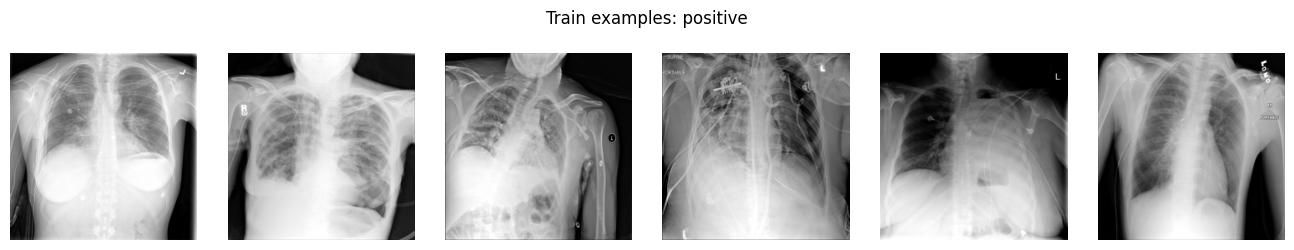

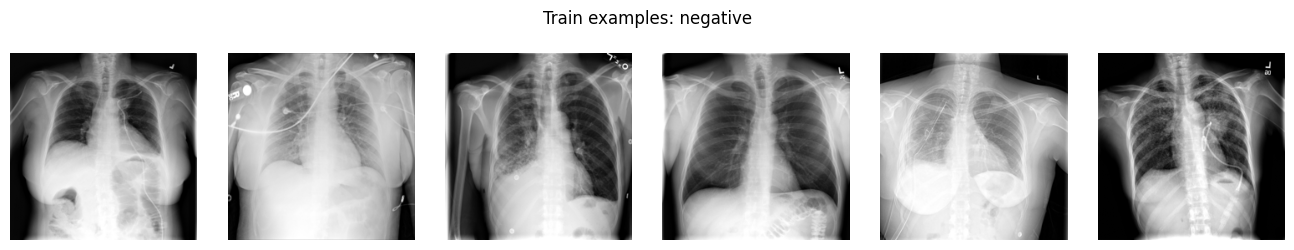

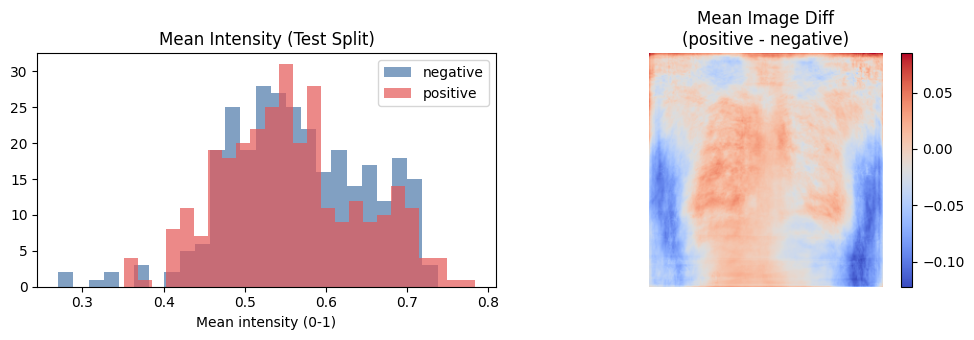

EDA prompt: overlap in simple intensity features suggests a harder task than frontal-vs-lateral.


In [37]:
def load_png_float(path):
    arr = np.asarray(Image.open(path).convert('L'), dtype=np.float32)
    return arr / 255.0


if ptx_train_manifest is None or ptx_test_manifest is None:
    print('Skipping PTX EDA because SIIM data prep did not complete.')
else:
    display(
        ptx_manifest.groupby(['split', 'label_name'])
        .size()
        .rename('count')
        .reset_index()
    )

    def show_examples(df, label, n=6, split='train'):
        subset = df[(df['label'] == label) & (df['split'] == split)]
        if subset.empty:
            print(f'No examples for split={split}, label={label}')
            return
        sample = subset.sample(n=min(n, len(subset)), random_state=42)
        fig, axes = plt.subplots(1, len(sample), figsize=(2.2 * len(sample), 2.5))
        if len(sample) == 1:
            axes = [axes]
        for ax, (_, row) in zip(axes, sample.iterrows()):
            ax.imshow(load_png_float(row['png_path']), cmap='gray')
            ax.axis('off')
        lbl = 'positive' if label == 1 else 'negative'
        plt.suptitle(f'{split.title()} examples: {lbl}')
        plt.tight_layout()
        plt.show()

    show_examples(ptx_manifest, label=1, n=6, split='train')
    show_examples(ptx_manifest, label=0, n=6, split='train')

    # Use test split for quick summary plots.
    test_df = ptx_test_manifest.copy()
    test_df['mean_intensity'] = test_df['png_path'].map(lambda p: load_png_float(p).mean())

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    ax[0].hist(
        test_df[test_df['label'] == 0]['mean_intensity'],
        bins=25,
        alpha=0.7,
        label='negative',
        color='#4c78a8',
    )
    ax[0].hist(
        test_df[test_df['label'] == 1]['mean_intensity'],
        bins=25,
        alpha=0.7,
        label='positive',
        color='#e45756',
    )
    ax[0].set_title('Mean Intensity (Test Split)')
    ax[0].set_xlabel('Mean intensity (0-1)')
    ax[0].legend()

    pos_paths = ptx_train_manifest[ptx_train_manifest['label'] == 1]['png_path'].tolist()
    neg_paths = ptx_train_manifest[ptx_train_manifest['label'] == 0]['png_path'].tolist()

    pos_mean = np.mean([load_png_float(p) for p in pos_paths[:200]], axis=0)
    neg_mean = np.mean([load_png_float(p) for p in neg_paths[:200]], axis=0)
    diff = pos_mean - neg_mean

    im = ax[1].imshow(diff, cmap='coolwarm')
    ax[1].set_title('Mean Image Diff\n(positive - negative)')
    ax[1].axis('off')
    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print('EDA prompt: overlap in simple intensity features suggests a harder task than frontal-vs-lateral.')


## Section 16: Traditional ML Baseline for Pneumothorax
We build a strong traditional baseline:
- Features: HOG + intensity histogram + regional means
- Model: Logistic Regression with `class_weight='balanced'`

Primary metric for this imbalanced task: **PR-AUC**.


Extracting handcrafted features for train/test...
Traditional ML PTX metrics:


/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,accuracy,precision,recall_sensitivity,specificity,f1,roc_auc,pr_auc,tp,tn,fp,fn
0,0.6783,0.6709,0.7,0.6567,0.6852,0.7395,0.7274,210,197,103,90


              precision    recall  f1-score   support

    negative       0.69      0.66      0.67       300
    positive       0.67      0.70      0.69       300

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600



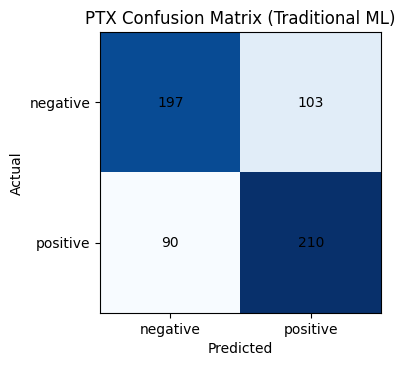

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

try:
    from skimage.feature import hog
except Exception as exc:
    hog = None
    print(f'skimage hog import failed: {exc}')


def ptx_binary_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision,
        'recall_sensitivity': recall,
        'specificity': specificity,
        'f1': f1,
        'roc_auc': roc_auc_score(y_true, y_prob),
        'pr_auc': average_precision_score(y_true, y_prob),
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
    }
    return metrics, y_pred, cm


def handcrafted_hog_features(png_path):
    arr = load_png_float(png_path)

    hog_vec = hog(
        arr,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True,
    )

    hist, _ = np.histogram(arr, bins=16, range=(0, 1), density=True)

    h, w = arr.shape
    center = arr[h // 4: 3 * h // 4, w // 4: 3 * w // 4].mean()
    upper = arr[: h // 2, :].mean()
    lower = arr[h // 2 :, :].mean()

    return np.concatenate([hog_vec, hist, np.array([center, upper, lower], dtype=np.float32)])


if ptx_train_manifest is None or ptx_test_manifest is None:
    print('Skipping traditional PTX baseline because SIIM data prep did not complete.')
    ptx_ml_metrics = None
elif hog is None:
    print('Skipping traditional PTX baseline because HOG extractor is unavailable.')
    ptx_ml_metrics = None
else:
    print('Extracting handcrafted features for train/test...')

    X_train_feat = np.vstack([handcrafted_hog_features(p) for p in ptx_train_manifest['png_path']])
    y_train_ptx = ptx_train_manifest['label'].to_numpy(dtype=int)

    X_test_feat = np.vstack([handcrafted_hog_features(p) for p in ptx_test_manifest['png_path']])
    y_test_ptx = ptx_test_manifest['label'].to_numpy(dtype=int)

    ptx_lr_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear', random_state=42)),
    ])
    ptx_lr_model.fit(X_train_feat, y_train_ptx)

    ptx_ml_prob = ptx_lr_model.predict_proba(X_test_feat)[:, 1]
    ptx_ml_metrics, ptx_ml_pred, ptx_ml_cm = ptx_binary_metrics(y_test_ptx, ptx_ml_prob, threshold=0.5)

    print('Traditional ML PTX metrics:')
    display(pd.DataFrame([ptx_ml_metrics]).round(4))
    print(classification_report(y_test_ptx, ptx_ml_pred, target_names=['negative', 'positive']))

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(ptx_ml_cm, cmap='Blues')
    ax.set_title('PTX Confusion Matrix (Traditional ML)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['negative', 'positive'])
    ax.set_yticks([0, 1], ['negative', 'positive'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(ptx_ml_cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()


## Section 17: Deep Learning Baseline for Pneumothorax (ResNet18 Transfer Learning)
We now use transfer learning with ResNet18 on the same split:
- Input size: `224x224`
- Optimizer: `AdamW`
- Weighted loss for class imbalance
- Metrics: same as traditional baseline


Epoch 01 | train_loss=0.5676 | train_acc=0.706 | val_acc=0.793
Epoch 02 | train_loss=0.3789 | train_acc=0.836 | val_acc=0.803
Epoch 03 | train_loss=0.2847 | train_acc=0.885 | val_acc=0.770
Epoch 04 | train_loss=0.1842 | train_acc=0.931 | val_acc=0.788
Epoch 05 | train_loss=0.1248 | train_acc=0.954 | val_acc=0.818
Epoch 06 | train_loss=0.1025 | train_acc=0.963 | val_acc=0.735
Epoch 07 | train_loss=0.1134 | train_acc=0.960 | val_acc=0.838
Epoch 08 | train_loss=0.0703 | train_acc=0.976 | val_acc=0.827


,epoch,train_loss,train_acc,val_acc
0,1,0.567627,0.7060,0.793333
1,2,0.378880,0.8355,0.803333
2,3,0.284739,0.8850,0.770000
3,4,0.184243,0.9315,0.788333
4,5,0.124758,0.9535,0.818333
5,6,0.102534,0.9630,0.735000
6,7,0.113438,0.9600,0.838333
7,8,0.070297,0.9760,0.826667


Deep Learning PTX metrics:


,accuracy,precision,recall_sensitivity,specificity,f1,roc_auc,pr_auc,tp,tn,fp,fn
0,0.78,0.7877,0.7667,0.7933,0.777,0.8714,0.8757,230,238,62,70


              precision    recall  f1-score   support

    negative       0.77      0.79      0.78       300
    positive       0.79      0.77      0.78       300

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



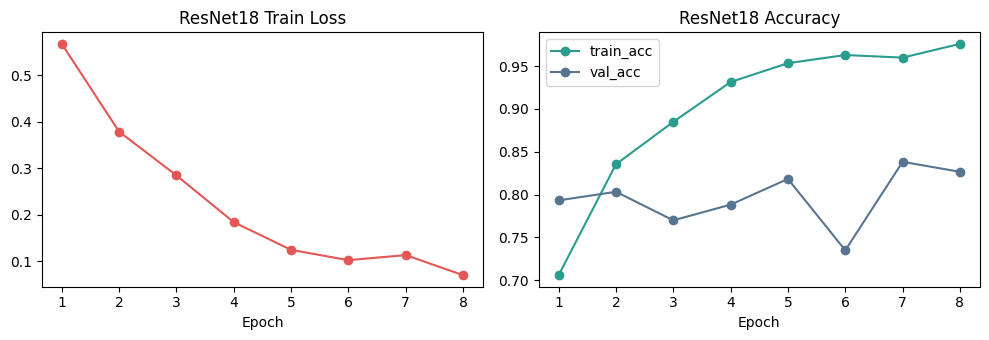

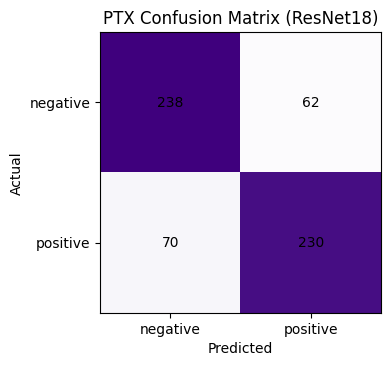

In [40]:
try:
    import torchvision
    from torchvision import transforms
    from torchvision.models import resnet18, ResNet18_Weights
except Exception as exc:
    torchvision = None
    print(f'torchvision import failed: {exc}')


class SIIMPNGDataset(torch.utils.data.Dataset):
    def __init__(self, manifest_df, transform=None):
        self.df = manifest_df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['png_path']).convert('RGB')
        y = int(row['label'])
        if self.transform is not None:
            x = self.transform(img)
        else:
            x = transforms.ToTensor()(img)
        return x, y


def evaluate_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_probs)


if ptx_train_manifest is None or ptx_val_manifest is None or ptx_test_manifest is None:
    print('Skipping deep PTX baseline because SIIM data prep did not complete.')
    ptx_dl_metrics = None
elif torchvision is None:
    print('Skipping deep PTX baseline because torchvision is unavailable.')
    ptx_dl_metrics = None
else:
    train_tf = transforms.Compose([
        transforms.RandomRotation(degrees=7),
        transforms.ToTensor(),
    ])
    eval_tf = transforms.Compose([
        transforms.ToTensor(),
    ])

    ds_train = SIIMPNGDataset(ptx_train_manifest, transform=train_tf)
    ds_val = SIIMPNGDataset(ptx_val_manifest, transform=eval_tf)
    ds_test = SIIMPNGDataset(ptx_test_manifest, transform=eval_tf)

    # Notebook-safe setting: avoid multiprocessing worker pickling issues on macOS/Windows/Jupyter.
    num_workers = 0
    pin_memory = torch.cuda.is_available()

    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    dl_test = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    try:
        weights = ResNet18_Weights.IMAGENET1K_V1
        ptx_cnn_model = resnet18(weights=weights)
    except Exception as exc:
        print(f'Could not load pretrained weights ({exc}). Falling back to random init.')
        ptx_cnn_model = resnet18(weights=None)

    ptx_cnn_model.fc = nn.Linear(ptx_cnn_model.fc.in_features, 2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ptx_cnn_model = ptx_cnn_model.to(device)

    train_labels = ptx_train_manifest['label'].to_numpy(dtype=int)
    counts = np.bincount(train_labels)
    class_weights = torch.tensor([
        len(train_labels) / max(counts[0], 1),
        len(train_labels) / max(counts[1], 1),
    ], dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(ptx_cnn_model.parameters(), lr=1e-4, weight_decay=1e-4)

    n_epochs = 8
    history = []

    for epoch in range(1, n_epochs + 1):
        ptx_cnn_model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for xb, yb in dl_train:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = ptx_cnn_model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            running_correct += (logits.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / max(total, 1)
        train_acc = running_correct / max(total, 1)

        y_val, p_val = evaluate_probs(ptx_cnn_model, dl_val, device)
        val_pred = (p_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_val, val_pred)

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        })

        print(f'Epoch {epoch:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}')

    hist_df = pd.DataFrame(history)
    display(hist_df)

    y_test, p_test = evaluate_probs(ptx_cnn_model, dl_test, device)
    ptx_dl_metrics, ptx_dl_pred, ptx_dl_cm = ptx_binary_metrics(y_test, p_test, threshold=0.5)

    print('Deep Learning PTX metrics:')
    display(pd.DataFrame([ptx_dl_metrics]).round(4))
    print(classification_report(y_test, ptx_dl_pred, target_names=['negative', 'positive']))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    ax[0].plot(hist_df['epoch'], hist_df['train_loss'], marker='o', color='#e45756')
    ax[0].set_title('ResNet18 Train Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(hist_df['epoch'], hist_df['train_acc'], marker='o', label='train_acc', color='#2a9d8f')
    ax[1].plot(hist_df['epoch'], hist_df['val_acc'], marker='o', label='val_acc', color='#577590')
    ax[1].set_title('ResNet18 Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(ptx_dl_cm, cmap='Purples')
    ax.set_title('PTX Confusion Matrix (ResNet18)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['negative', 'positive'])
    ax.set_yticks([0, 1], ['negative', 'positive'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(ptx_dl_cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()


## Section 18: Compare Traditional ML vs Deep Learning (Pneumothorax)
Primary success metric: **PR-AUC**.

Target teaching outcome:
- Deep learning should improve PR-AUC and/or sensitivity over traditional ML on this harder pathology task.
- If not, discuss label quality, sample size, and training budget.


,Model,Accuracy,Sensitivity,Specificity,F1,ROC-AUC,PR-AUC
0,Traditional ML (HOG + LR),0.6783,0.7000,0.6567,0.6852,0.7395,0.7274
1,Deep Learning (ResNet18),0.7800,0.7667,0.7933,0.7770,0.8714,0.8757


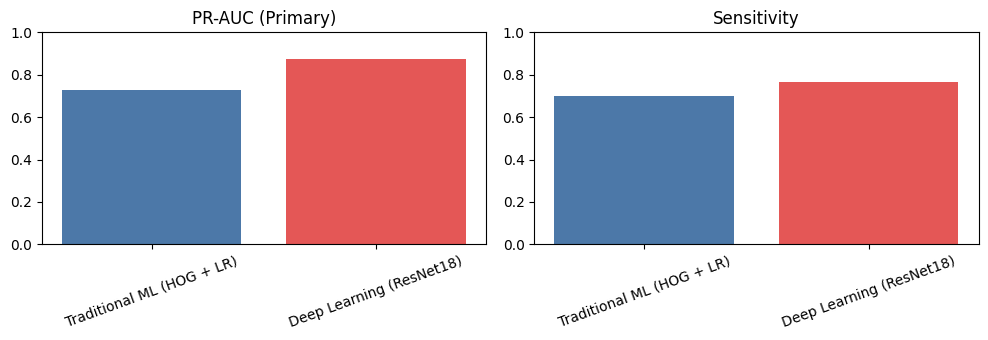

PR-AUC improvement (Deep - Traditional): 0.1483
Success criterion met: deep learning improved PR-AUC by at least +0.05.
Optional robustness check: rerun with 3 different random seeds and compare mean PR-AUC.


In [41]:
if ptx_ml_metrics is None or ptx_dl_metrics is None:
    print('Run both PTX model cells first to compare.')
else:
    ptx_compare_df = pd.DataFrame([
        {
            'Model': 'Traditional ML (HOG + LR)',
            'Accuracy': ptx_ml_metrics['accuracy'],
            'Sensitivity': ptx_ml_metrics['recall_sensitivity'],
            'Specificity': ptx_ml_metrics['specificity'],
            'F1': ptx_ml_metrics['f1'],
            'ROC-AUC': ptx_ml_metrics['roc_auc'],
            'PR-AUC': ptx_ml_metrics['pr_auc'],
        },
        {
            'Model': 'Deep Learning (ResNet18)',
            'Accuracy': ptx_dl_metrics['accuracy'],
            'Sensitivity': ptx_dl_metrics['recall_sensitivity'],
            'Specificity': ptx_dl_metrics['specificity'],
            'F1': ptx_dl_metrics['f1'],
            'ROC-AUC': ptx_dl_metrics['roc_auc'],
            'PR-AUC': ptx_dl_metrics['pr_auc'],
        },
    ])

    display(ptx_compare_df.round(4))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    ax[0].bar(ptx_compare_df['Model'], ptx_compare_df['PR-AUC'], color=['#4c78a8', '#e45756'])
    ax[0].set_ylim(0, 1)
    ax[0].set_title('PR-AUC (Primary)')
    ax[0].tick_params(axis='x', rotation=20)

    ax[1].bar(ptx_compare_df['Model'], ptx_compare_df['Sensitivity'], color=['#4c78a8', '#e45756'])
    ax[1].set_ylim(0, 1)
    ax[1].set_title('Sensitivity')
    ax[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

    delta_pr = ptx_dl_metrics['pr_auc'] - ptx_ml_metrics['pr_auc']
    print(f'PR-AUC improvement (Deep - Traditional): {delta_pr:.4f}')

    if delta_pr >= 0.05:
        print('Success criterion met: deep learning improved PR-AUC by at least +0.05.')
    elif delta_pr > 0:
        print('Deep learning improved PR-AUC, but by less than +0.05.')
    else:
        print('No PR-AUC gain from deep learning in this run. Recheck data quality, tuning, and sample size.')

    print('Optional robustness check: rerun with 3 different random seeds and compare mean PR-AUC.')


## Final Wrap-up: Matching Model Complexity to Task Difficulty
- **Frontal vs lateral** is often easy enough that traditional ML can be excellent.
- **Pneumothorax detection** is harder and usually benefits from deep learning on spatial patterns.
- The right model depends on the clinical question, label quality, and data scale.
